In [ ]:
# Marital status - 配偶者の有無
# Application mode - 応募形態
# Application order - 応募順序
# Course - コース
# Daytime/evening attendance - 昼間/夜間の出席
# Previous qualification - 以前の資格
# Previous qualification (grade) - 以前の資格（成績）
# Nacionality - 国籍
# Mother's qualification - 母親の資格
# Father's qualification - 父親の資格
# Mother's occupation - 母親の職業
# Father's occupation - 父親の職業
# Admission grade - 入学成績
# Displaced - 移住者
# Educational special needs - 教育的特別支援
# Debtor - 債務者
# Tuition fees up to date - 授業料の支払い状況
# Gender - 性別
# Scholarship holder - 奨学生
# Age at enrollment - 入学時の年齢
# International - 国際的
# Curricular units 1st sem (credited) - 1学期の履修単位（認定済み）
# Curricular units 1st sem (enrolled) - 1学期の履修単位（登録済み）
# Curricular units 1st sem (evaluations) - 1学期の履修単位（評価済み）
# Curricular units 1st sem (approved) - 1学期の履修単位（合格済み）
# Curricular units 1st sem (grade) - 1学期の履修単位（成績）
# Curricular units 1st sem (without evaluations) - 1学期の履修単位（未評価）
# Curricular units 2nd sem (credited) - 2学期の履修単位（認定済み）
# Curricular units 2nd sem (enrolled) - 2学期の履修単位（登録済み）
# Curricular units 2nd sem (evaluations) - 2学期の履修単位（評価済み）
# Curricular units 2nd sem (approved) - 2学期の履修単位（合格済み）
# Curricular units 2nd sem (grade) - 2学期の履修単位（成績）
# Curricular units 2nd sem (without evaluations) - 2学期の履修単位（未評価）
# Unemployment rate - 失業率
# Inflation rate - インフレ率
# GDP - 国内総生産

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from optuna.samplers import TPESampler
import optuna
import warnings

/home/ru/kaggle/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("../inputs/train.csv")
test = pd.read_csv("../inputs/test.csv")

In [3]:
x_train = train.drop(columns=["Target", "id"], axis=1)
y_train = train["Target"]
x_test = test.drop(columns=["id"], axis=1)

In [4]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

In [20]:
train4crr = train.copy()
train4crr["Target"] = le.transform(train4crr["Target"])

In [30]:
train.isna().sum().sort_values(ascending=False)

id                                                0
Curricular units 2nd sem (credited)               0
International                                     0
Curricular units 1st sem (credited)               0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (approved)               0
Curricular units 1st sem (grade)                  0
Curricular units 1st sem (without evaluations)    0
Curricular units 2nd sem (enrolled)               0
Marital status                                    0
Curricular units 2nd sem (evaluations)            0
Curricular units 2nd sem (approved)               0
Curricular units 2nd sem (grade)                  0
Curricular units 2nd sem (without evaluations)    0
Unemployment rate                                 0
Inflation rate                                    0
GDP                                               0
Age at enrollment                                 0
Scholarship 

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [32]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,76518.0,38258.500000,22088.988286,0.00,19129.250000,38258.500000,57387.750000,76517.000
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000


In [36]:
columns = train.columns.tolist()
for column in columns:
    print(f"Unique Value: {sorted(train[column].unique())}")
    print(f"Statistic Info: {train[column].describe()}\n")
    print('-------------------------------------------------')

Unique Value: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

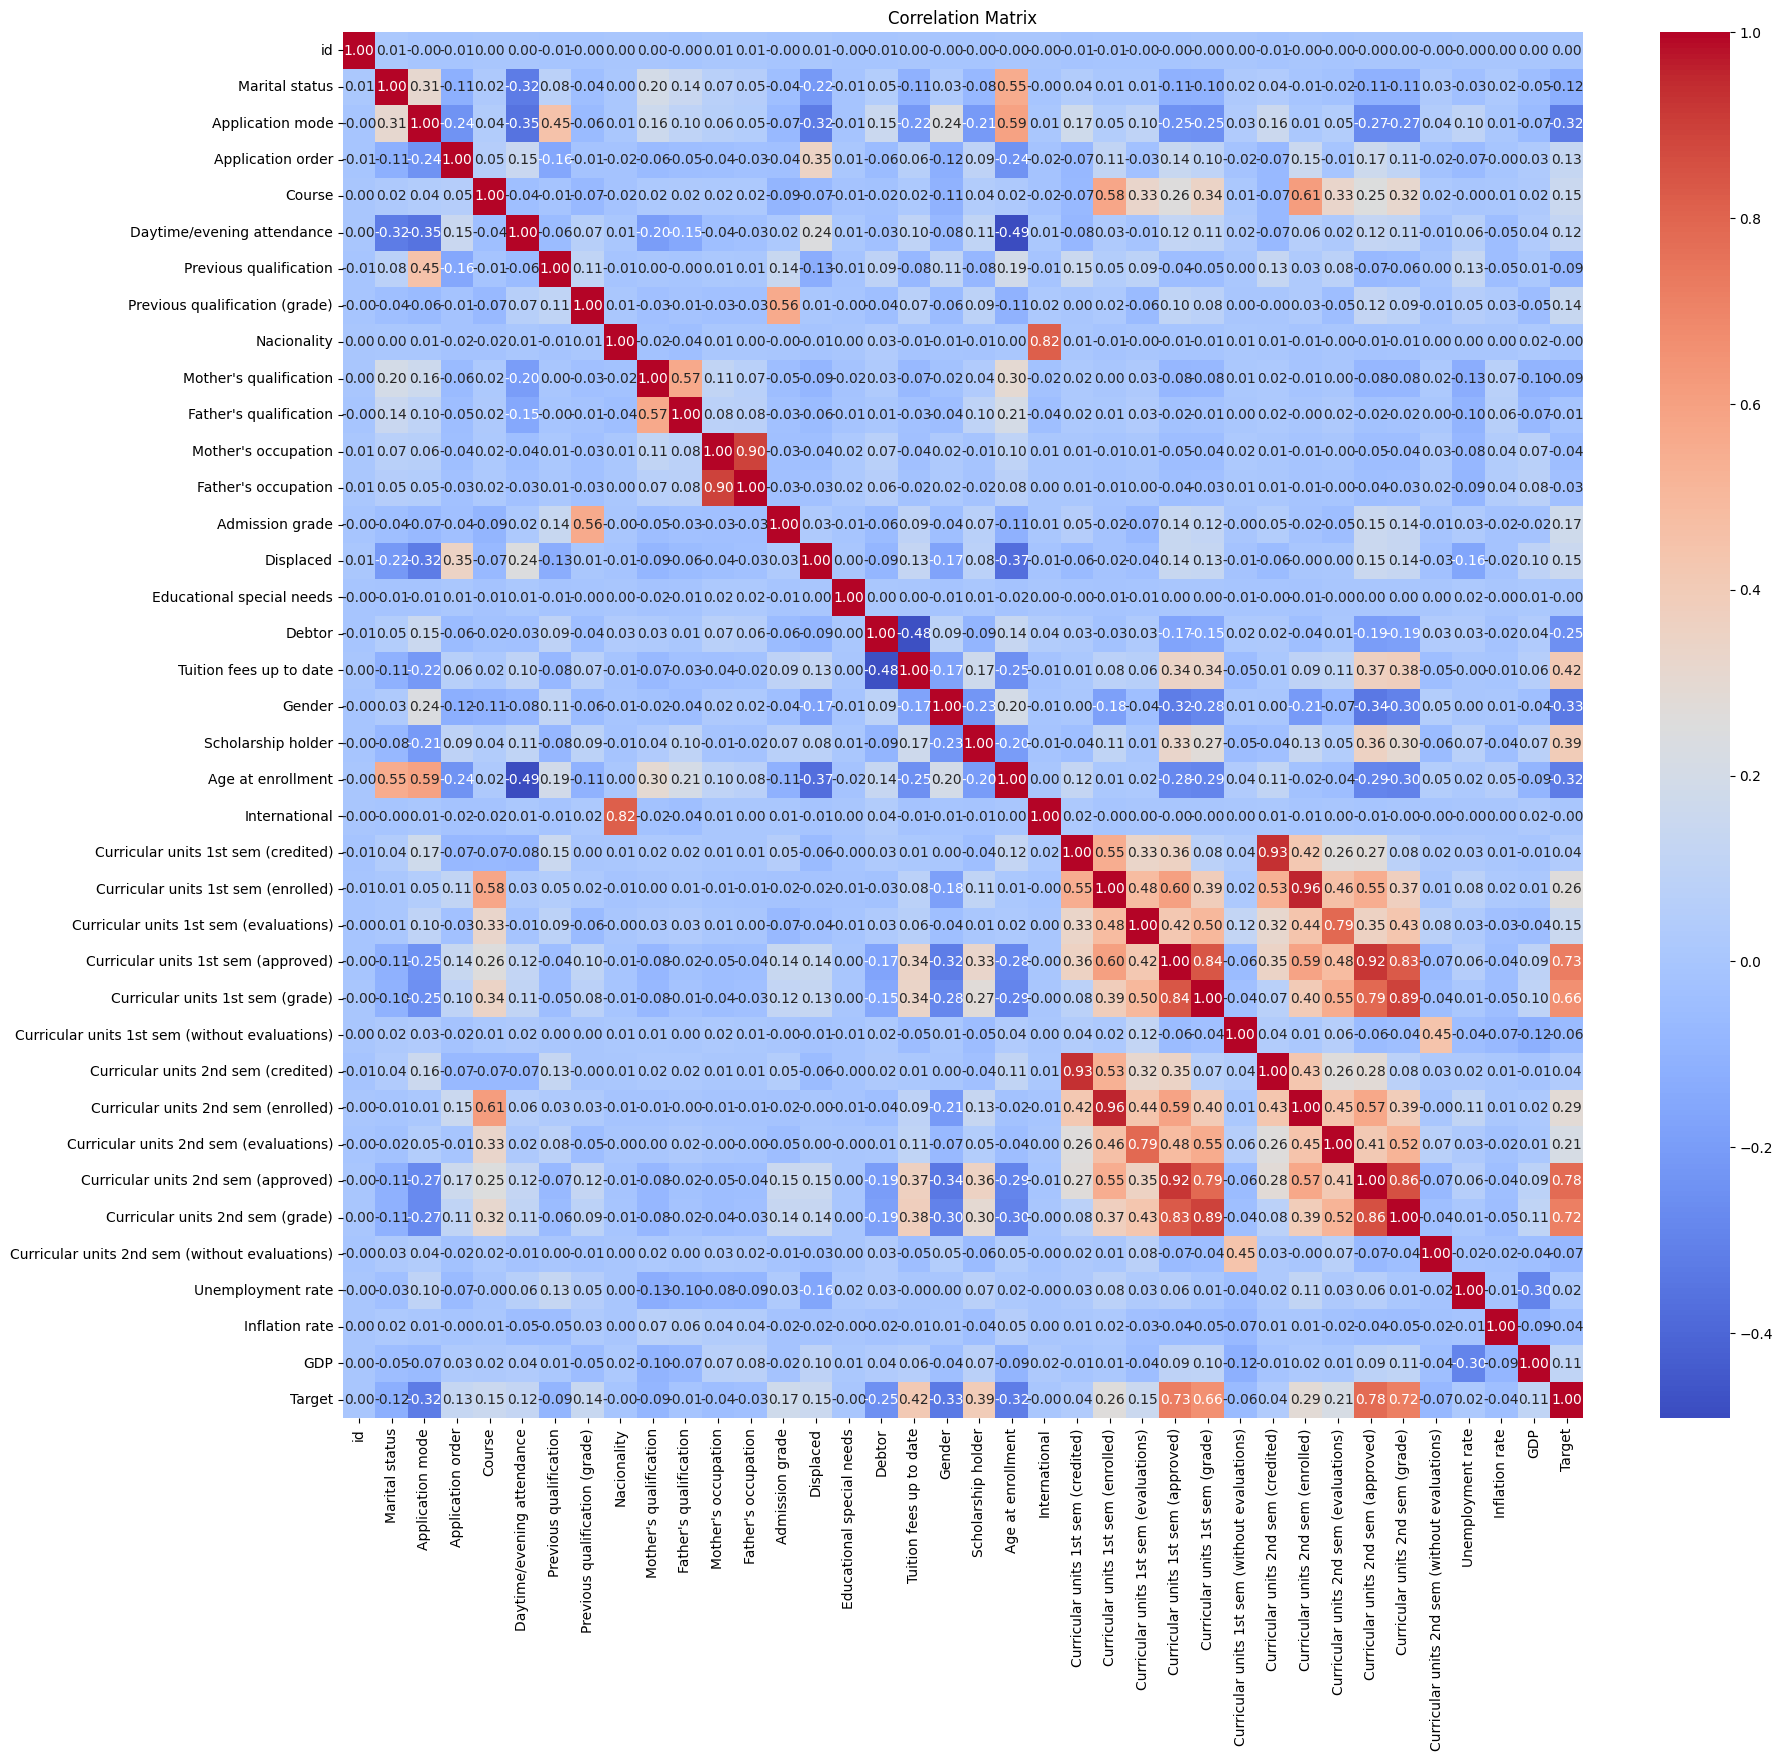

In [21]:
correlation_matrix = train4crr.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig("../img/correlation_matrix.png")
plt.show()

In [ ]:
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df['set'] = 'train'
    data_df = pd.concat([data_df, test.copy()]).fillna('test')
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
for feature in x_train.columns:
  plot_distribution_pairs(x_train, x_test, feature, palette=color_list)